In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.device_count())            # Numero di GPU disponibili
  print(torch.cuda.get_device_name(0))        # Nome della prima GPU disponibile
  print(torch.cuda.current_device())        # Device in uso al momento
  print(torch.cuda.set_device(0))             # Imposta la prima GPU come default
  print(torch.cuda.get_device_capability(0))  # Verifica le capacità della prima GPU

1
Tesla T4
0
None
(7, 5)


In [ ]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/CIDDS_Meta/CIDDS_Meta.csv'
dataset = pd.read_csv(path)

### ***PRE-ELABORAZIONE DATI***

In [ ]:
dataset

,Duration,Proto,Packets,Bytes,Flows,Flags,Tos,multilabel
0,0.245,TCP,2,670,1,.AP...,0,normal
1,0.000,TCP,1,66,1,.A....,0,normal
2,0.000,TCP,1,58,1,....S.,0,portScan
3,0.000,TCP,1,58,1,....S.,0,portScan
4,0.047,TCP,11,1027,1,.AP...,0,normal
...,...,...,...,...,...,...,...,...
399995,0.034,TCP,2,598,1,.AP...,0,normal
399996,0.000,TCP,1,95,1,.AP...,32,normal
399997,0.005,TCP,5,479,1,.AP.SF,0,dos
399998,0.000,TCP,1,66,1,.A...F,32,normal


In [ ]:
print(Counter(dataset['Flows']))
print(Counter(dataset['multilabel']))

dataset = dataset.drop('Flows', axis=1)

Counter({1: 400000})
Counter({'normal': 243363, 'dos': 117904, 'portScan': 37723, 'pingScan': 646, 'bruteForce': 364})


In [ ]:
dep_var = 'multilabel'
cat_names = ["Proto", "Flags", "Bytes"]
cont_names = [col for col in dataset.columns if col not in cat_names and col != dep_var]

print(cont_names, 'len: ', len(cont_names))

['Duration', 'Packets', 'Tos'] len:  3


In [ ]:
# LabelEncoding della variabile target 
target_index = dataset.columns.get_loc(dep_var)
dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[dep_var])

#LabelEncoding delle variabili categoriali
for col in cat_names:
  target_index = dataset.columns.get_loc(col)
  dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[col])

In [ ]:
cont_names = [col for col in dataset.columns if col != dep_var]

print(cont_names)

['Duration', 'Proto', 'Packets', 'Bytes', 'Flags', 'Tos']


In [ ]:
dataset

,Duration,Proto,Packets,Bytes,Flags,Tos,multilabel
0,0.245,2,2,11030,12,0,2
1,0.000,2,1,10946,4,0,2
2,0.000,2,1,10024,1,0,4
3,0.000,2,1,10024,1,0,4
4,0.047,2,11,233,12,0,2
...,...,...,...,...,...,...,...
399995,0.034,2,2,10228,12,0,2
399996,0.000,2,1,13159,12,32,2
399997,0.005,2,5,8690,15,0,1
399998,0.000,2,1,10946,5,32,2


In [ ]:
print(Counter(dataset['multilabel']))

Counter({2: 243363, 1: 117904, 4: 37723, 3: 646, 0: 364})


In [ ]:
target_dict = {'bruteForce' : 0,
               'dos' : 1,
               'normal' : 2,
               'pingScan' : 3,
               'portScan' : 4}

In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [ ]:
y_train = train[dep_var]
train = train.drop(dep_var, axis=1)
y_test = test[dep_var]
test = test.drop(dep_var, axis=1)

# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=(10000/len(train)), random_state=0)

In [ ]:
"""Visto che nel dataset la variabile target è molto squilibrata lo amplio con una generazione
 randomica di dati mediante la tecnica chiamata Synthetic Minority Over-sampling Technique (SMOTE)"""

sampling_strategy = {0: 20000, 3: 20000}

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = sampling_strategy, random_state=42)
x_sm, y_train = sm.fit_resample(train, y_train)
train = pd.DataFrame(x_sm,columns=train.columns)

In [ ]:
#y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_val))

Counter({2: 115665, 1: 55910, 0: 20000, 3: 20000, 4: 17941})
Counter({2: 121584, 1: 59074, 4: 18846, 3: 298, 0: 198})
Counter({2: 6114, 1: 2920, 4: 936, 3: 23, 0: 7})


In [ ]:
train

,Duration,Proto,Packets,Bytes,Flags,Tos
0,0.000000,2.0,1.0,10946.0,5.0,32.0
1,0.000000,2.0,1.0,11756.0,6.0,32.0
2,0.000000,2.0,1.0,9509.0,8.0,0.0
3,0.006000,2.0,6.0,9574.0,15.0,0.0
4,0.005000,2.0,5.0,8690.0,15.0,0.0
...,...,...,...,...,...,...
229511,0.123532,0.0,2.0,12502.0,0.0,0.0
229512,0.000000,0.0,1.0,7848.0,0.0,0.0
229513,0.123000,0.0,2.0,12502.0,0.0,0.0
229514,0.001543,0.0,1.0,7848.0,0.0,0.0


In [ ]:
test

,Duration,Proto,Packets,Bytes,Flags,Tos
175966,0.000,2,1,10946,4,0
242975,0.003,2,6,9574,15,0
303194,0.003,2,3,3724,7,0
367177,0.067,2,3,9333,14,0
248827,0.005,2,4,5177,7,0
...,...,...,...,...,...,...
118065,0.005,2,5,8690,15,0
332486,0.265,2,13,1932,15,0
196684,0.007,2,5,8690,15,0
101236,0.006,2,5,8690,15,0


In [ ]:
validation

,Duration,Proto,Packets,Bytes,Flags,Tos
269906,0.000,2,1,694,12,32
197818,0.000,2,1,9642,4,0
195222,0.056,2,5,13053,14,0
291473,0.410,2,3,3056,12,0
351884,0.004,2,5,8690,15,0
...,...,...,...,...,...,...
129206,0.000,0,1,11364,0,192
20135,0.030,2,3,4287,13,0
101442,0.000,2,1,10946,4,0
48347,0.006,2,6,9574,15,0


### ***MODEL***

In [ ]:
""" Pytorch Dataset e DataLoader
Estendiamo la Datasetclasse (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class CIDDS_Dataset(Dataset):
    def __init__(self, X, Y):
        X = X.copy()
        self.X = X.copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = CIDDS_Dataset(train, y_train)
valid_ds = CIDDS_Dataset(validation, y_val)

In [ ]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
class CIDDSModel(nn.Module):
    def __init__(self, n_cont):
        super().__init__()
        self.n_cont =  n_cont
        self.lin1 = nn.Linear(self.n_cont, 200)
        self.lin2 = nn.Linear(200, 100)
        self.lin3 = nn.Linear(100, 5)
        self.bn1 = nn.BatchNorm1d(self.n_cont, momentum=1.0)
        self.bn2 = nn.BatchNorm1d(200, momentum=1.0)
        self.bn3 = nn.BatchNorm1d(100, momentum=1.0)
        #self.drops = nn.Dropout(0.00001)
        

    def forward(self, x_cont):
        x = self.bn1(x_cont)
        x = F.relu(self.lin1(x))
        #x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        #x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [ ]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output = model(x)
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    print('valid loss ', sum_loss/total, ' and accuracy ', correct/total)
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print('ep ', i, " training loss: ", loss)
        val_loss(model, valid_dl)

### ***TRAINING***

In [ ]:
""" Ora addestriamo il modello sul set di addestramento. Ho usato l'ottimizzatore Adam per ottimizzare la perdita di entropia incrociata. 
L'addestramento è piuttosto semplice: iterare attraverso ogni batch, eseguire un passaggio in avanti, calcolare i gradienti, 
eseguire una discesa del gradiente e ripetere questo processo per tutte le epoche necessarie. """ 

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [ ]:
model = CIDDSModel(len(cont_names))
to_device(model, device)

CIDDSModel(
  (lin1): Linear(in_features=6, out_features=200, bias=True)
  (lin2): Linear(in_features=200, out_features=100, bias=True)
  (lin3): Linear(in_features=100, out_features=5, bias=True)
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(200, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
)

In [ ]:
train_loop(model, epochs=500, lr=0.00008)

ep  0  training loss:  0.49836702261797694
valid loss  0.1919153579235077  and accuracy  0.9589
ep  1  training loss:  0.15396028815942706
valid loss  0.234397740650177  and accuracy  0.9697
ep  2  training loss:  0.1004868601487545
valid loss  4.401644498252868  and accuracy  0.9699
ep  3  training loss:  0.078913691233656
valid loss  0.06917644340991974  and accuracy  0.9786
ep  4  training loss:  0.06497160072854698
valid loss  0.06011707645058632  and accuracy  0.9819
ep  5  training loss:  0.05917807847365827
valid loss  0.053764922672510145  and accuracy  0.9897
ep  6  training loss:  0.054877192758329016
valid loss  0.04321585251688957  and accuracy  0.9853
ep  7  training loss:  0.05082448431930661
valid loss  0.08417292122840882  and accuracy  0.969
ep  8  training loss:  0.04791555380794323
valid loss  0.06596859434843064  and accuracy  0.9808
ep  9  training loss:  0.04595687293833805
valid loss  0.12238265590667724  and accuracy  0.9839
ep  10  training loss:  0.04389143015

### ***PREDICTION***

In [ ]:
""" Effettuiamo le predizioni sul dataset di test """

test_ds = CIDDS_Dataset(test, np.zeros(len(test)))
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

# Utilizziamo la funzione softmax poiché siamo interessati alla probabilità per ogni classe
preds = []
model.eval()
with torch.no_grad():
    for x, y in test_dl:
        out = model(x)
        prob = F.softmax(out, dim=1)
        preds.append(prob)
        
y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [ ]:
y_pred

array([2, 1, 1, ..., 1, 1, 2])

### ***EVALUATION***

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({2: 121584, 1: 59074, 4: 18846, 3: 298, 0: 198})
Pred: Counter({2: 121394, 1: 59075, 4: 18508, 3: 669, 0: 354})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

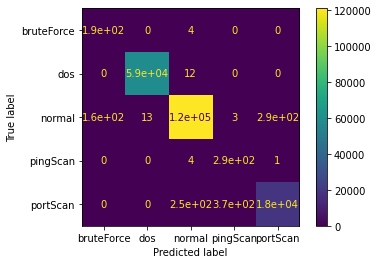

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[199642    160]
  [     4    194]]

 [[140913     13]
  [    12  59062]]

 [[ 78144    272]
  [   462 121122]]

 [[199326    376]
  [     5    293]]

 [[180867    287]
  [   625  18221]]]


In [ ]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [   194  59062 121122    293  18221]
True negative:  [199642 140913  78144 199326 180867]
False positive:  [160  13 272 376 287]
False negative:  [  4  12 462   5 625]
True positive rate:  [0.97979798 0.99979686 0.99620016 0.98322148 0.96683646]
True negative rate:  [0.99919921 0.99990775 0.99653132 0.99811719 0.99841571]
False positive rate:  [8.00792785e-04 9.22469949e-05 3.46867986e-03 1.88280538e-03
 1.58428740e-03]
False negative rate:  [0.02020202 0.00020314 0.00379984 0.01677852 0.03316354]


In [ ]:
print(cm)

[[   194      0      4      0      0]
 [     0  59062     12      0      0]
 [   160     13 121122      3    286]
 [     0      0      4    293      1]
 [     0      0    252    373  18221]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.55      0.98      0.70       198
           1       1.00      1.00      1.00     59074
           2       1.00      1.00      1.00    121584
           3       0.44      0.98      0.61       298
           4       0.98      0.97      0.98     18846

    accuracy                           0.99    200000
   macro avg       0.79      0.99      0.86    200000
weighted avg       1.00      0.99      0.99    200000



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.99446
Precision_weighted:  0.9958267793633506
Recall_weighted:  0.99446
mcc:  0.9896537535823418
f2:  0.9947330556439477
